# Генерация структуры молекулы по альфа-спирали
## Подготовка
Загрузим библиотеку fpgen (высокоуровневую обертку над ESM3, созданную в рамках проекта)

In [1]:
from IPython.display import clear_output

! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

clear_output()

In [ ]:
import random

from fpgen.generator import ProteinGenerator
from fpgen.metrics import Metric

from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein
from esm.utils.structure.protein_chain import ProteinChain

Выгрузим из базы данных белок GFP и зададим альфа спираль. Альфа спираль — список из индексов структуры, которые не будут замаскированы (нумерация начинается с 0)

In [4]:
gfp_protein = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb('1qy3', chain_id='A')
)
gfp_aplha_phelix = [5, 133, 9, 138, 11, 139, 13, 140, 15, 141, 142, 180, 147, 181, 24, 182, 26, 32, 33, 34, 162, 164, 37, 38, 39, 166, 41, 43, 50, 178, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 198, 202, 204, 79, 81, 82, 85, 215, 89, 217, 91, 92, 93, 219, 221, 222, 97, 103, 105, 109, 116, 118, 120, 122]

Создадим объект модели ESM3 и генератор на его основе

In [5]:
model = ESM3.from_pretrained('esm3-open').to('cuda')
gfp_generator = ProteinGenerator(gfp_protein, gfp_aplha_phelix, model)

/opt/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/opt/conda/lib/python3.11/site-packages/esm/models/vqvae.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore


В библиотеке уже есть заготовленная функция для подсчета RMSD по всей структуре белка. Но нет для подсчета по альфа-спирали (по техническим причинам). Поэтому ее необходимо реализовать самостоятельно

In [6]:
# Функция принимает на вход сгенерированный белок и белок, на основе которого мы производили генерацию. А также
# список с индексами альфа-спирали. И возвращает на выходе значение метрики
def phelix_rmsd(generation_protein, template_protein, alpha_phelix) -> float:
    template_chain: ProteinChain = template_protein.to_protein_chain()
    generation_chain: ProteinChain = generation_protein.to_protein_chain()

    rmsd = template_chain[alpha_phelix].rmsd(generation_chain[alpha_phelix])
    return rmsd

In [7]:
import os
os.environ['DISABLE_ITERATIVE_SAMPLING_TQDM'] = '1'

In [8]:
from tqdm import trange

## Генерация
Создадим переменные для хранения сгенерированных белков

In [53]:
data = [] # Информация для анализа
proteins = [] # Структура и последовательность белков

И начнем генерацию белковых молекул

In [54]:
for _ in trange(300):
    # Случайно выбираем температуру
    temperature = random.uniform(0.0, 1.5)

    # Генерируем белок, передавая на вход список метрик, температуру и флаг fix_protein=True, который означает,
    # что мы хотим получить полную структуру молекулы (а не только скелет), добавив недостающие атомы
    protein, metric = gfp_generator.generate(
        metric_list=[
            Metric(phelix_rmsd, alpha_phelix=gfp_aplha_phelix, calculate_on_full_atom=True),
            Metric('rmsd', calculate_on_full_atom=True),
            'ptm',
            'plddt',
            'identity'
        ],
        temperature=temperature,
        fix_protein=True
    )

    data.append(metric + [temperature])
    proteins.append(protein['full_atom'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [38:40<00:00,  7.73s/it]


Сохраняем данные в датафрейм (так удобнее работать)

In [56]:
import pandas as pd
metrics_df = pd.DataFrame(data, columns=['alpha_rmsd', 'full_rmsd', 'ptm', 'plddt', 'identity', 'temperature'])

In [57]:
metrics_df.head()

,alpha_rmsd,full_rmsd,ptm,plddt,identity,temperature
0,1.467277,1.720697,0.845491,0.889637,0.407725,1.225379
1,1.824570,2.495011,0.848626,0.883532,0.457265,0.245705
2,1.571710,2.149830,0.862063,0.888149,0.436681,1.286259
3,1.997596,2.437820,0.756539,0.761424,0.436123,1.496759
4,1.790959,2.347659,0.842802,0.865365,0.462555,0.907759


## Анализ сгенерированных белков

<Axes: xlabel='alpha_rmsd', ylabel='Count'>

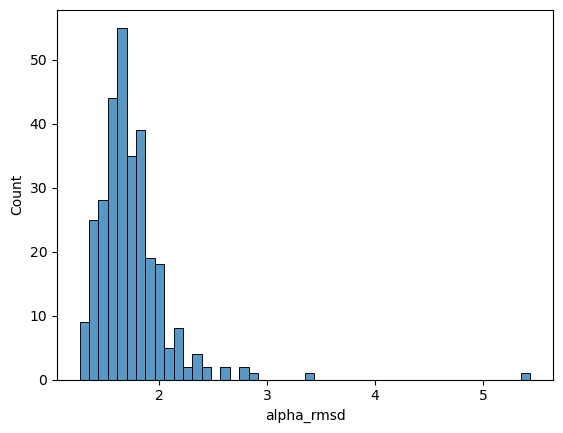

In [58]:
import seaborn as sns
sns.histplot(data=metrics_df, x='alpha_rmsd')

<Axes: xlabel='full_rmsd', ylabel='Count'>

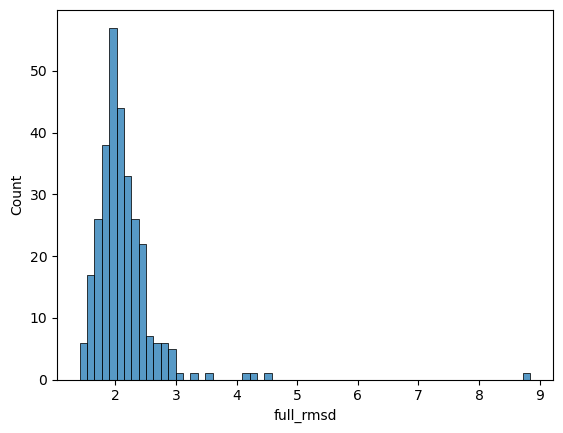

In [59]:
sns.histplot(data=metrics_df, x='full_rmsd')

<Axes: xlabel='ptm', ylabel='Count'>

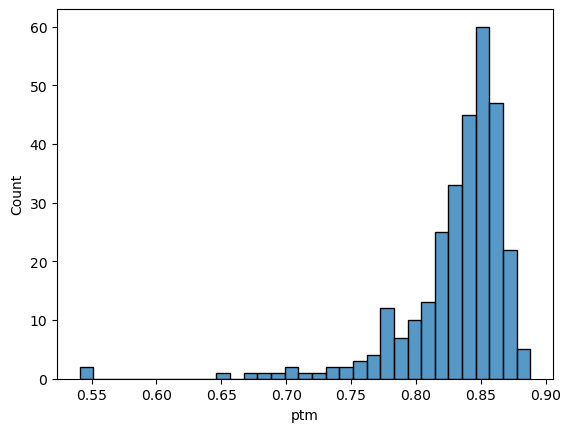

In [60]:
sns.histplot(data=metrics_df, x='ptm')

<Axes: xlabel='plddt', ylabel='Count'>

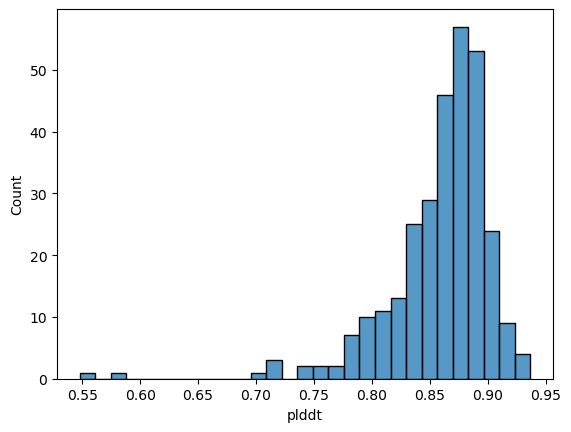

In [61]:
sns.histplot(data=metrics_df, x='plddt')

<Axes: xlabel='identity', ylabel='Count'>

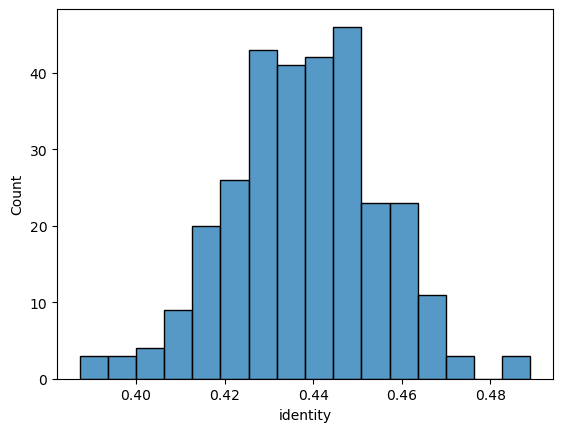

In [62]:
import seaborn as sns
sns.histplot(data=metrics_df, x='identity')

In [63]:
metrics_df_filtered = metrics_df[(metrics_df['alpha_rmsd'] <= 1.5) & (metrics_df['full_rmsd'] <= 1.5)]
metrics_df_filtered

,alpha_rmsd,full_rmsd,ptm,plddt,identity,temperature
63,1.263184,1.409898,0.866909,0.897248,0.456140,0.443437
190,1.370681,1.444292,0.876857,0.907539,0.452174,0.749214
222,1.295569,1.441263,0.856098,0.884410,0.436123,0.306040


In [47]:
from fpgen.visualization import plot_protein
plot_protein(proteins[21])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [50]:
proteins[21].sequence

'MFADGFGKPVPIEVSLTASVNGVDFTVTGKGTGDAASGKLDLTFTSSVPSLPVPWPTLVTTLTYGVQCFSRYPAELADKDFFKRVMPEGYTQEAVLTFSDGSKYVTTGEVYVENGVLVNEITLKQYPGTNPEKIANPNLEYNYGSFTVPIHTDTATNTFSYEFTIDHTVNGKKVGTVDHEQQNTVKGNPAEFYDLNGYLDIKSTLILPKSGSENSMKLDETVTFVLK'

In [52]:
proteins[21].to_pdb('gfp_5_2.pdb')